In [2]:
import os, sys
HOME = '/workspace/wilson'  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [12]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars
import shutil


from model import MLP3, MLP4, InstancedModule, normal, custom_kaiming_uniform
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

device = t.device("cuda" if t.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load original intersect run

In [4]:
# original intersect run
# MODEL_DIR = '/workspace/models/2024-11-12_20-54-10_S5_A5x2_MLP2_128_ubias_wd2e-5'
MODEL_DIR = '/workspace/models/2024-12-19_01-41-15_S5_A5x2_MLP2_128_ubias_wd2e-5'
init_models, params = load_models(MODEL_DIR, sel=0)
final_models, _ = load_models(MODEL_DIR, sel='final')
init_models = init_models[0]
final_models = final_models[0]
data = GroupData(params)
group = data.groups[0]

/workspace/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


Intersection size: 7920/14400 (0.55)
Added 7920 elements from intersection
Added 0 elements from group 0: S(5)
Added 0 elements from group 1: times(A(5), Z(2))
Train set size: 7920/14400 (0.55)


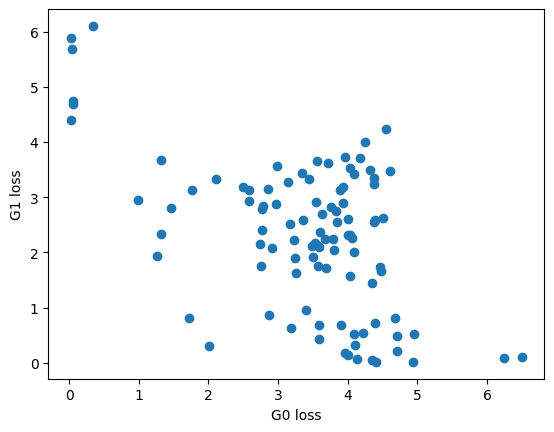

In [5]:
loss_dict = test_loss(final_models.to(device), data)
plt.scatter(loss_dict['G0_loss'].detach().cpu().numpy(), loss_dict['G1_loss'].detach().cpu().numpy())
plt.xlabel('G0 loss')
plt.ylabel('G1 loss')
plt.show()

In [15]:
print('G0 grokked', (loss_dict['G0_loss'] < 0.05).nonzero())
print('G1 grokked', (loss_dict['G1_loss'] < 0.05).nonzero())

G0 grokked tensor([[10],
        [31],
        [95]], device='cuda:0')
G1 grokked tensor([[30],
        [43]], device='cuda:0')


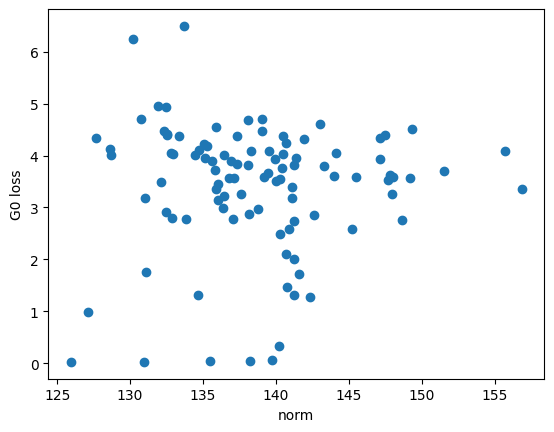

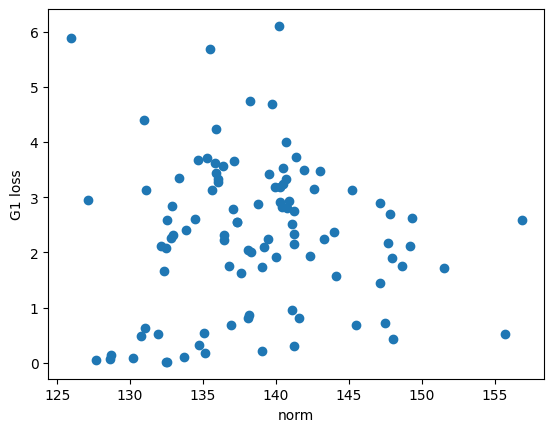

In [16]:
norms = [weight_norm(final_models[i]) for i in range(len(final_models))]
plt.scatter(norms, loss_dict['G0_loss'].detach().cpu().numpy())
plt.xlabel('norm')
plt.ylabel('G0 loss')
plt.show()
plt.scatter(norms, loss_dict['G1_loss'].detach().cpu().numpy())
plt.xlabel('norm')
plt.ylabel('G1 loss')
plt.show()

In [14]:
init_norms = [weight_norm(init_models[i]) for i in range(len(init_models))]
final_norms = [weight_norm(final_models[i]) for i in range(len(final_models))]
np.mean(init_norms), np.mean(final_norms)

(np.float64(263.9629931640625), np.float64(138.64923721313477))

In [49]:
inst1 = 31  # grokked G0
inst2 = 10 # grokked G0
# inst2 = 30  # grokked G1
interp_params = copy.deepcopy(params)
interp_params.instances = 101
interp_models = MLP2(interp_params).to(device)
for i, a in enumerate(np.arange(0, 1.01, 0.01)):
    for name, p in interp_models.named_parameters():
        p.data[i] = a * final_models[inst1].get_parameter(name).data + (1 - a) * final_models[inst2].get_parameter(name).data

In [50]:
train_loader = DataLoader(
    dataset=data,
    batch_size=len(data),
    drop_last=True,
)
x, z = next(iter(train_loader))
out = interp_models(x.to(device))
interp_train_loss = get_cross_entropy(out, z.to(device))
interp_test_loss = test_loss(interp_models, data)

In [51]:
interp_train_loss.shape

torch.Size([101])

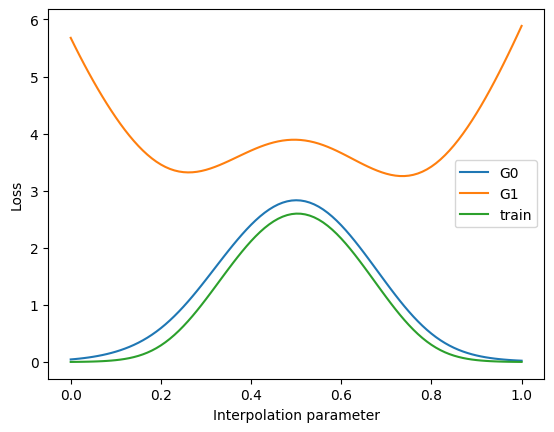

In [52]:
plt.plot(np.arange(0, 1.01, 0.01), interp_test_loss['G0_loss'].detach().cpu().numpy(), label='G0')
plt.plot(np.arange(0, 1.01, 0.01), interp_test_loss['G1_loss'].detach().cpu().numpy(), label='G1')
plt.plot(np.arange(0, 1.01, 0.01), interp_train_loss.detach().cpu().numpy(), label='train')
plt.xlabel('Interpolation parameter')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
np.arange(0, 1.01, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

### Noise scale sweep; write perturbed ckpts

In [85]:
inst = int(loss_dict['G0_loss'].argmin().item())
print(inst, loss_dict['G0_loss'][inst], loss_dict['G1_loss'][inst])

31 tensor(0.0239, device='cuda:0') tensor(5.8868, device='cuda:0')


In [62]:
NOISE_SCALES = [0] + [2**i for i in range(-30, 1, 2)] 
COPIES = 20

In [63]:
def get_noised_models(model, noise_scales=NOISE_SCALES, copies=COPIES):
    model = model.to(device)
    ret = []
    for noise_scale in noise_scales:
        for _ in range(copies):
            noised_model = copy.deepcopy(model)
            for name, p in noised_model.named_parameters():
                if 'embedding_' in name:   # match 'embedding_left' and 'embedding_right' but not 'unembedding'
                    noise = normal(p.shape).to(device).data * noise_scale
                elif 'bias' in name:
                    noise = t.empty(p.shape, device=device)
                    bound = 1 / np.sqrt(p.shape[0])    # 1 / sqrt(fan_in)
                    noise.uniform_(-bound, bound)
                    noise *= noise_scale
                else:
                    noise = custom_kaiming_uniform(p.shape, scale=noise_scale).to(device).data
                p.data += noise
            ret.append(noised_model)
    return MLP2.stack(ret)

In [91]:
init_noised_models = get_noised_models(init_models[inst].to(device))
final_noised_models = get_noised_models(final_models[inst].to(device))

In [68]:
PERTURB_DIR = f'{MODEL_DIR}/perturb_ckpts'
os.makedirs(PERTURB_DIR, exist_ok=True)

In [92]:
os.makedirs(PERTURB_DIR, exist_ok=True)
t.save(init_noised_models.state_dict(), f'{PERTURB_DIR}/inst{inst}_noisesweep_2e-30_2e0_20_epoch000000.pt')
t.save(final_noised_models.state_dict(), f'{PERTURB_DIR}/inst{inst}_noisesweep_2e-30_2e0_20_epoch002000.pt')

In [98]:
print(f'{PERTURB_DIR}/inst{inst}_noisesweep_2e-30_2e0_20_epoch000000.pt')

/workspace/models/2024-12-19_01-41-15_S5_A5x2_MLP2_128_ubias_wd2e-5/perturb_ckpts/inst31_noisesweep_2e-30_2e0_20_epoch000000.pt


In [93]:
noised_params = copy.deepcopy(params)
noised_params.instances = len(NOISE_SCALES) * COPIES
noised_models_all = MLP2(noised_params)
noised_models_all.load_state_dict(t.load(f'{PERTURB_DIR}/inst{inst}_noisesweep_2e-30_2e0_20_epoch000000.pt'))

/tmp/ipykernel_38918/3005794816.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noised_models_all.load_state_dict(t.load(f'{PERTURB_DIR}/inst{inst}_noisesweep_2e-30_2e0_

<All keys matched successfully>

In [94]:
lembed = init_models[inst].embedding_left
noise_lembed = noised_models_all.embedding_left

In [95]:
lembed[0,:5,:5]

tensor([[ 3.8656e-02, -8.6705e-01, -9.5232e-01,  4.6828e-01,  1.9244e-01],
        [ 7.5724e-01,  7.3303e-01, -1.2151e-01, -3.9818e-01,  1.6127e+00],
        [-1.5815e-01,  2.6616e-01, -7.1954e-01,  8.5882e-03,  1.6865e+00],
        [ 9.7669e-01,  3.0363e-01,  1.6597e-03, -5.7904e-01,  1.4477e-01],
        [-2.4553e-01,  6.4067e-01,  1.6528e-01, -1.3897e-01, -8.9165e-01]],
       grad_fn=<SliceBackward0>)

In [97]:
noise_lembed[200,:5,:5]

tensor([[ 0.0386, -0.8671, -0.9522,  0.4689,  0.1931],
        [ 0.7572,  0.7332, -0.1213, -0.3986,  1.6123],
        [-0.1587,  0.2664, -0.7197,  0.0088,  1.6868],
        [ 0.9762,  0.3040,  0.0020, -0.5793,  0.1449],
        [-0.2453,  0.6412,  0.1653, -0.1388, -0.8918]],
       grad_fn=<SliceBackward0>)

### Train noised models

In [121]:
B = t.load('/workspace/wilson/Finite-groups/models/2024-12-19_03-17-59_TEST_S5_A5x2_MLP2_128_ubias_wd2e-5_PERTURB_inst31_noisesweep_2e-30_2e0_20_epoch000000/ckpts/000001.pt')

/tmp/ipykernel_38918/793597326.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  B = t.load('/workspace/wilson/Finite-groups/models/2024-12-19_03-17-59_TEST_S5_A5x2_MLP2_1

In [122]:
A = t.load('/workspace/models/2024-12-19_03-19-09_TEST_S5_A5x2_MLP2_128_ubias_wd2e-5/ckpts/000001.pt')

/tmp/ipykernel_38918/1877860581.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  A = t.load('/workspace/models/2024-12-19_03-19-09_TEST_S5_A5x2_MLP2_128_ubias_wd2e-5/ckpt

In [123]:
for k in A.keys():
    print(k)
    if not t.allclose(A[k][31], B[k][0]):
        print('BAD', (A[k][31] - B[k][0]).abs().max())

embedding_left
BAD tensor(1.7248e-06, device='cuda:0')
embedding_right
BAD tensor(1.2517e-06, device='cuda:0')
linear_left
BAD tensor(6.2261e-05, device='cuda:0')
linear_right
BAD tensor(0.0001, device='cuda:0')
unembedding
BAD tensor(3.1069e-06, device='cuda:0')
unembed_bias


In [124]:
opt_A = t.load('/workspace/models/opt_A.pt')
opt_B = t.load('/workspace/models/opt_B.pt')

/tmp/ipykernel_38918/2704714310.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  opt_A = t.load('/workspace/models/opt_A.pt')
/tmp/ipykernel_38918/2704714310.py:2: Future

In [126]:
opt_A['state']

{0: {'step': tensor(1.),
  'exp_avg': tensor([[-5.8529e-05, -1.3153e-05, -2.0756e-05,  ...,  2.3394e-04,
           -9.8930e-06,  6.4635e-05],
          [ 5.0884e-05, -4.4632e-05,  6.2880e-06,  ...,  1.0123e-04,
           -7.5667e-05,  1.5203e-04],
          [-2.2170e-05, -4.0289e-05, -9.5940e-05,  ..., -7.1015e-06,
           -9.7064e-05,  1.7237e-04],
          ...,
          [-1.1388e-04, -8.7212e-05,  2.6358e-05,  ..., -1.2817e-04,
            8.5044e-05, -4.8576e-05],
          [-1.3361e-04, -1.5398e-04, -1.1547e-04,  ...,  1.9725e-05,
           -2.1191e-04, -1.5305e-05],
          [ 3.0169e-05,  1.0525e-04,  4.2017e-05,  ...,  6.6975e-05,
           -1.0773e-05, -1.4947e-04]], device='cuda:0'),
  'exp_avg_sq': tensor([[6.8514e-09, 3.4598e-10, 8.6163e-10,  ..., 1.0945e-07, 1.9574e-10,
           8.3554e-09],
          [5.1784e-09, 3.9840e-09, 7.9078e-11,  ..., 2.0496e-08, 1.1451e-08,
           4.6227e-08],
          [9.8298e-10, 3.2464e-09, 1.8409e-08,  ..., 1.0086e-10, 1.8843e

In [131]:
for k in opt_A['state'].keys():
    print(k)
    if not t.allclose(opt_A['state'][k]['exp_avg_sq'][31], opt_B['state'][k]['exp_avg_sq'][0], rtol=0, atol=0):
        print('BAD', (opt_A['state'][k]['exp_avg_sq'][31] - opt_B['state'][k]['exp_avg_sq'][0]).abs().max())

0
BAD tensor(5.6843e-14, device='cuda:0')
1
BAD tensor(6.2450e-17, device='cuda:0')
2
BAD tensor(5.5511e-17, device='cuda:0')
3
BAD tensor(1.5277e-13, device='cuda:0')
4
BAD tensor(2.2382e-13, device='cuda:0')
5
BAD tensor(1.8829e-13, device='cuda:0')


### Examine noised models post training

In [6]:
# noise sweep ckpts
NOISE_RUN_DIR = '/workspace/models/2024-12-19_00-13-42_S5_A5x2_MLP2_128_ubias_wd2e-5_PERTURB_inst18_noisesweep_2e-30_2e0_20_epoch000000/'
noise_run_models, params = load_models(NOISE_RUN_DIR, sel='final')
noise_run_models = noise_run_models[0]

/workspace/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [7]:
losses = dict()
for i, noise_scale in enumerate(NOISE_SCALES):
    cur_noise_run_models = noise_run_models[i*COPIES:(i+1)*COPIES]
    loss_dict = test_loss(cur_noise_run_models.to(device), data)
    losses[noise_scale] = loss_dict['G0_loss']

In [8]:
losses[0]

tensor([1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476,
        1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476, 1.0476,
        1.0476, 1.0476], device='cuda:0')

/tmp/ipykernel_38918/3605754642.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


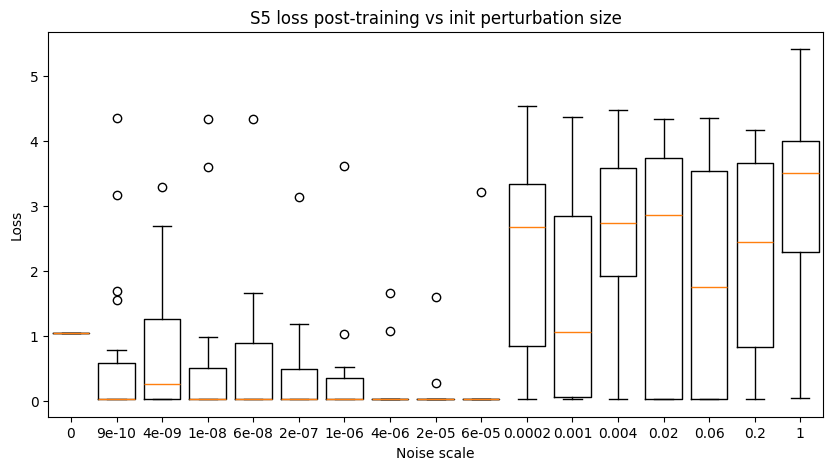

In [9]:
loss_data = np.array([v.cpu().numpy() for v in losses.values()]).T
plt.figure(figsize=(10, 5))
plt.boxplot(
    loss_data,
    labels=[f'{k:.1g}' for k in losses.keys()],
    widths=0.8,
)
plt.xlabel('Noise scale')
plt.ylabel('Loss')
plt.title('S5 loss post-training vs init perturbation size')
plt.show()

### Sweep over starting epoch

In [96]:
models, params = load_models(MODEL_DIR, sel=slice(0, -1, 10))  # saved at every 10 epochs. so this loads every 100 epochs.
data = GroupData(params)
group = data.groups[0]

  0%|          | 0/20 [00:00<?, ?it/s]/workspace/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model

Intersection size: 7920/14400 (0.55)
Added 7920 elements from intersection
Added 0 elements from group 0: S(5)
Added 0 elements from group 1: times(A(5), Z(2))
Train set size: 7920/14400 (0.55)


In [97]:
inst = 31
models = [model[inst] for model in models]
models = MLP2.stack(models)
len(models)

20

In [98]:
COPIES = 20
NOISE_SCALE = 1e-2
noised_models_epochs = []
for i in range(len(models)):   # over epochs
    noised_models_epochs.append(get_noised_models(models[i], copies=COPIES, noise_scales=[NOISE_SCALE]))
noised_models_epochs = MLP2.stack(noised_models_epochs)

In [99]:
len(noised_models_epochs)

400

In [100]:
t.save(noised_models_epochs.state_dict(), f'{PERTURB_DIR}/inst{inst}_epochsweep_0-2000_noise{NOISE_SCALE}.pt')

### Train noised models from different starting epochs

### Examine noised models post training

In [107]:
EPOCHSWEEP_DIR = '/workspace/models/2024-12-20_00-47-32_S5_A5x2_MLP2_128_ubias_wd2e-5_PERTURB_inst31_epochsweep_0-2000_noise0_01'
# EPOCHSWEEP_DIR = '/workspace/models/2024-12-19_23-23-23_S5_A5x2_MLP2_128_ubias_wd2e-5_PERTURB_inst31_epochsweep_0-2000_noise1e-3'
epochsweep_models, params = load_models(EPOCHSWEEP_DIR, sel='final')
epochsweep_models = MLP2.stack(epochsweep_models)

/workspace/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [108]:
losses = dict()
for i, epoch in enumerate(range(0, 2000, 100)):
    cur_models = epochsweep_models[i*COPIES:(i+1)*COPIES]
    loss_dict = test_loss(cur_models.to(device), data)
    losses[epoch] = loss_dict['G0_loss']

/tmp/ipykernel_7228/1170070490.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


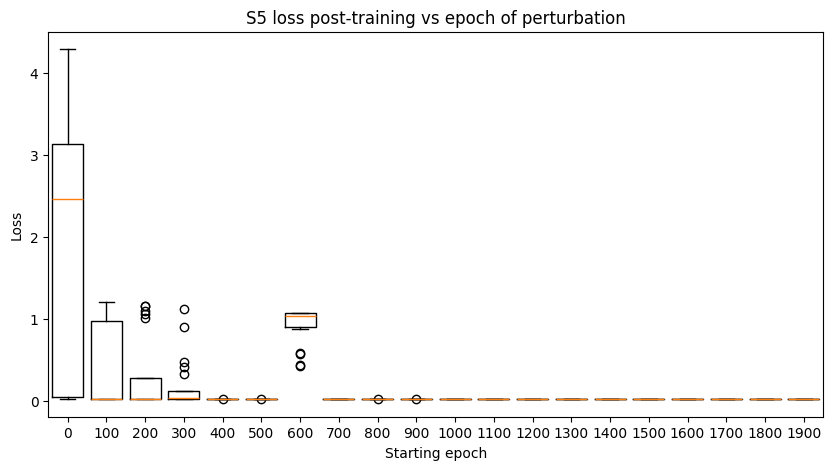

In [109]:
loss_data = np.array([v.cpu().numpy() for v in losses.values()]).T
plt.figure(figsize=(10, 5))
plt.boxplot(
    loss_data,
    labels=losses.keys(),
    widths=0.8,
)
plt.xlabel('Starting epoch')
plt.ylabel('Loss')
plt.title('S5 loss post-training vs epoch of perturbation')
plt.show()

In [91]:
[len(v) for v in losses.values()]

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20]